# Introduction

This workbook fits a Gaussian Process model to the Random and Sobol data. 

In [25]:
import GPy
import pandas as pd
import patsy as pt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
%matplotlib inline
import re
import pymc3 as pm
import matplotlib.ticker as tk
import re
from sklearn.model_selection import KFold
import pickle
from scipy.stats import norm

Get results and subset data to include 'random' method only. 

In [26]:
df = pd.read_csv('results/all_results_average.csv')
df = df.rename(columns={'lag_time': 't', 'n_components': 'm', 
                        'n_clusters': 'n', 'test_score': 'y'}).\
loc[:, ['basis', 'method', 'y', 't', 'm', 'n']]

idx = (df['method'] == 'bayesian') & (~df['basis'].isin(['ff_all_ang', 'ff_bb_ang', 'ff_re_ang', 'chi_tor']))
df = df.loc[idx, :]

Scale variables and add them back in - these are for making predictions with the GP models

In [27]:
to_scale = ['m', 'n', 't']
scaler = preprocessing.MinMaxScaler()
vars_scaled = pd.DataFrame(scaler.fit_transform(df.loc[:, to_scale]), 
                           columns=[x+'_s' for x in to_scale], 
                          index=df.index)

vars_scaled = df.loc[:, ['y', 'basis']].join(vars_scaled)

Make the dummy coded basis variables

In [28]:
X = vars_scaled.filter(regex='(_s$|basis)')
y = vars_scaled.loc[:, 'y']
X_c = pt.dmatrix('0 + t_s + m_s + n_s+ C(basis)', data=X, return_type='dataframe')
X_c = X_c.rename(columns=lambda x: re.sub('C|\\(|\\)|\\[|\\]','',x))


# Response surface


### Create grid

In [29]:
new_N = 10

# Create new matrix
chi_new, m_new, n_new, t_new = np.meshgrid(np.unique(X['basis'].values), 
                                           np.unique(np.sort(X['m_s'].values)), 
                                           np.linspace(0, 1, new_N), np.linspace(0, 1, new_N))
X_new = np.array([chi_new.flatten(), m_new.flatten(), n_new.flatten(), t_new.flatten()]).T

# One hot encoding for basis function
X_new = pd.DataFrame(X_new, columns=['basis', 'm_s', 'n_s', 't_s'])
for x in ['m_s', 'n_s', 't_s']:
    X_new.loc[:, x] = X_new.loc[:, x].astype(float) 
X_new_c = pt.dmatrix('0 + t_s + m_s + n_s+ C(basis)', data=X_new, return_type='dataframe')
X_new_c = X_new_c.rename(columns=lambda x: re.sub('C|\\(|\\)|\\[|\\]','',x))



### Make predictions on the grid

In [30]:
mod = pickle.load(open('results/all_chi_bayesian-opt_mml_model.p', 'rb'))
model = mod['model']
mp = mod['mp']
gp = mod['gp']

with model:
    mu, var = gp.predict(X_new_c.values, point=mp, diag=True,pred_noise=False)
    _,  var2 = gp.predict(X_new_c.values, point=mp, diag=True,pred_noise=True)


Add the grid predictions in a dataframe, rescale and tidy variables for plotting

In [31]:

# put predictions in dataframe
rsm_df = X_new_c.copy(deep=True)
rsm_df['f'] = mu
rsm_df['sigma_n'] = np.sqrt(var2)
rsm_df['sigma_f'] = np.sqrt(var)
rsm_df.loc[:, 'basis'] = X_new.loc[:, 'basis']

# Scale values back up
tmp = scaler.inverse_transform(rsm_df.loc[:, ['m_s', 'n_s', 't_s']])
for i, x in enumerate(to_scale):
    rsm_df.loc[:, x] = tmp[:, i]

# do some rounding to make plots better
n_min = 10 # Because of rounding problems
rsm_df.loc[:, 'm'] = np.round(rsm_df.loc[:, 'm'], 0).astype(int)
rsm_df.loc[:, 'n'] = np.maximum(np.round(rsm_df.loc[:, 'n'], 0).astype(int), np.repeat(n_min, rsm_df.shape[0]))
rsm_df.loc[:, 't'] = np.round(rsm_df.loc[:, 't']*2, 0)/2

rsm_df = rsm_df.loc[:, ['basis', 'm', 'n', 't', 'f', 'sigma_n', 'sigma_f']]

In [32]:
mp_df = pd.DataFrame(mp, index=['mp']).T.reset_index()
mp_df = mp_df.loc[~mp_df['index'].str.contains('log'), :]
mp_df.loc[mp_df['index'].str.contains('basis'), :].sort_values(by='mp')

,index,mp
13,l_basisall_tor,0.719796
19,l_basiskappa_angle,1.489535
18,l_basishb_pairs,3.767834
14,l_basisalpha_angle,8.376317
15,l_basisca_cont,20.385817
16,l_basisclose-h_cont,26.059684
17,l_basisclose_cont,28.844974


### Plotting surface
plot the surface for best and worst basis functions (as judged by the max relevance). Always plot 'm' on the x-axis with one other variable on y-axis, hold the third variable at it's median value. 

In [33]:
titles = {'close-h_cont': 'Closest Heavy Atom Contact', 
          'all_tor': 'All torsions',
          'alpha_angle': r'C$\alpha$ torsion', 
          'kappa_angle': r'$\kappa$ angle', 
         't': r'$\tau$', 'm': r'$m$','n': r'$n$', 
          'ppo_tor':r'$\phi, \psi, \omega$ torsions'}
y_vars = ['t', 'n']
to_plot = pd.DataFrame(rsm_df.groupby('basis')['f'].max()).reset_index().sort_values(by='f', ascending=False).iloc[[0, -1], 0]
to_plot = list(to_plot)
# to_plot = ['alpha_angle','kappa_angle']

# Get medians for plotting
n_vals = np.sort(np.unique(rsm_df['n']))
n_median = n_vals[int(n_vals.shape[0]/2)]
t_vals = np.sort(np.unique(rsm_df['t']))
t_median = t_vals[int(t_vals.shape[0]/2)]
medians = {'t': t_median, 'n': n_median}

# Color coding min/max
vmin = 1.4
vmax = 2.2


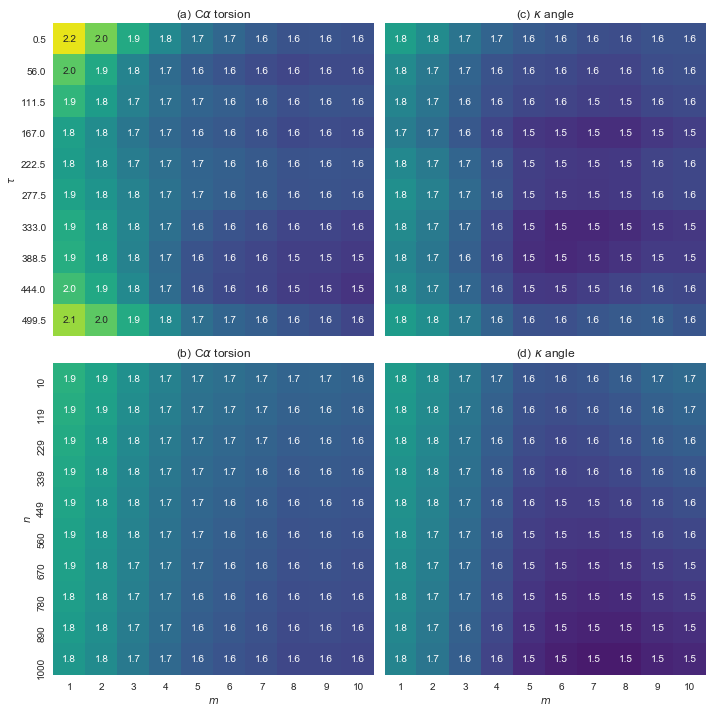

In [34]:

# plot
with sns.plotting_context(font_scale=1.25):
    fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey='row')
    for j, chi in enumerate(to_plot):
        for i, y_var in enumerate(y_vars):
            # Select dataset
            cont = [x for x in y_vars if x != y_var][0]
            tmp = rsm_df.loc[np.abs(rsm_df[cont]-medians[cont]) < 1e-6, :]
            tmp_p = tmp.loc[tmp['basis']==chi, [y_var, 'm', 'f']].pivot(index=y_var, columns='m', values='f')
            sns.heatmap(tmp_p, cmap='viridis', square=False, yticklabels=1, annot=True, fmt="3.1f", 
                        ax=axes[i, j], cbar=False, vmin=vmin, vmax=vmax)
            let = list('abcdefg')[len(to_plot)*j + i]
            axes[i, j].set_title('({0}) {1}'.format(let, titles[chi]))
            if(j==0):
                axes[i, j].set_ylabel(titles[y_var])
            else:
                axes[i, j].set_ylabel("")
            if(i==1):
                axes[i, j].set_xlabel(titles['m'])
            else:
                axes[i, j].set_xlabel('')
    plt.tight_layout(h_pad=1)
    plt.savefig('figures/all_chi_bayesian-opt_surface_high-low.png', dpi=450, bbox_inches='tight')

## Value vs rank - observation, predictions, response surface

Plot the:

1. observations, 
2. the predictions at the observation inputs and
3. values of the response surface over the grid

against rank. 


First get the predictions

In [35]:
with model:
    mu, var = gp.predict(X_c.values, point=mp, diag=True,pred_noise=False)
    mu, var2 = gp.predict(X_c.values, point=mp, diag=True,pred_noise=True)
mu_max = np.max(mu) # the incumbent - for later


Put all the predictions, observations and response surface into one dataframe for plotting. 

In [36]:
# Observations dataframe
obs_df = df.loc[:, ['basis', 'm', 'n', 't', 'y']].rename(columns={'y':'f'})
obs_df['sigma_f'] = 0
obs_df['sigma_n'] = 0
obs_df['type'] = 'Observations'

# predictions
pred_df = obs_df.copy(deep=True)
pred_df.loc[:, 'f'] = mu
pred_df.loc[:, 'sigma_f'] = np.sqrt(var)
pred_df.loc[:, 'sigma_n'] = np.sqrt(var2)
pred_df.loc[:, 'type'] = 'Predictions'

# rsm: 
rsm_df.loc[:, 'type'] = 'Response Surface'

# total
tot_df = pd.concat([obs_df, pred_df, rsm_df.sample(frac=0.5)], axis=0, sort=False)

In [89]:
np.sort(mu)[::-1]

array([2.2786225 , 2.2786225 , 2.2786225 , ..., 1.39588507, 1.39569631,
       1.37703812])

Rank and melt for plotting. 

In [90]:
def melt_and_rank(df, grp, val):
    
    df.loc[:, 'Rank'] = df.groupby(grp)[val].rank(ascending=False, method='first')
    
    df_l = df.loc[:, [grp, 'Rank', 'basis',  'sigma_f', 'sigma_n']]\
        .merge(df.melt(id_vars=[grp, 'Rank'],value_vars=[ val, 'm', 'n', 't']), 
              on=['Rank', grp], how='inner')

    # Create the correct error variables
    df_l.loc[df_l['variable'].isin(to_scale), ['sigma_f', 'sigma_n']] = 0
    df_l.loc[:, 'err_f'] = 2*df_l.loc[:, 'sigma_f'] 
    df_l.loc[:, 'err_y'] = 2*df_l.loc[:, 'sigma_n'] 

    # relabel
    labels = {'kappa_angle': r'$\kappa$ angle', 'ca_cont': r'$C \alpha$ contact', 
                            'close-h_cont': 'Heavy contact', 'close_cont': 'Closest contact', 
                            'drid': 'DRID', 'n': r'$n$', 't': r'$\tau$', 
                            'hb_pairs': 'BH distance', 'ppo_tor': 'Backbone torsions', 
                            'all_tor': 'All torsions', 'alpha_angle': r'$C \alpha$ torsion', 
                            'm': r'$m$', 'f': r'$f(X)$', 'basis': r'$\chi$', 
              'ei': '$\mathbb{E}[I]$'}
    df_l.loc[:, 'variable'] = df_l.loc[:, 'variable'].apply(lambda x: labels[x])
    df_l.loc[:, 'basis'] = df_l.loc[:, 'basis'].apply(lambda x: labels[x])

    df_l = df_l.rename(columns=labels)
    return df_l
    
tot_df_l= melt_and_rank(tot_df, 'type', 'f')

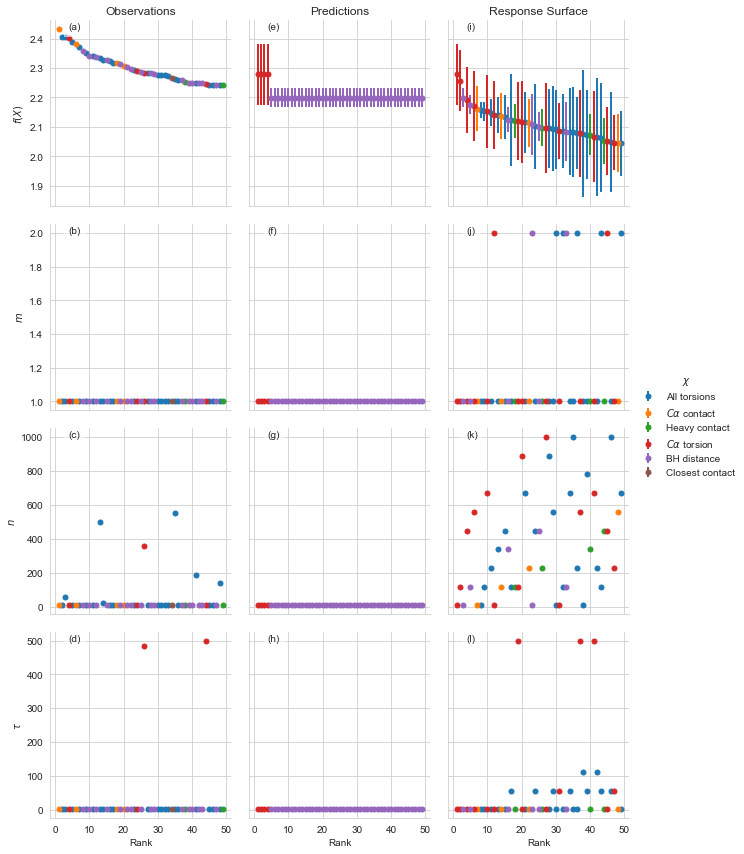

In [92]:
with sns.plotting_context(font_scale=1.25):
    sns.set_style('whitegrid')

    g = sns.FacetGrid(data=tot_df_l.query('Rank < 50'), row='variable', 
                      col='type', hue=r'$\chi$', 
                      sharey='row', sharex='col')
    g.map(plt.errorbar, 'Rank', 'value', 'err_f', lw=0, elinewidth=2, 
          marker='o', ms=5).add_legend()
#     g.map(plt.errorbar, 'Rank', 'value', 'err_y', lw=0, elinewidth=1, 
#           marker='o', ms=5).add_legend()
    g.fig.subplots_adjust(wspace=0.1, hspace=0.1)
    g.set_titles('')
    for i in range(g.axes.shape[0]):
        g.axes[i, 0].set_ylabel(g.row_names[i])
    for i in range(g.axes.shape[1]):
        g.axes[0, i].set_title(g.col_names[i])
    for i, ax in enumerate(g.axes.flatten(order='F')):
        ax.annotate('({0})'.format(list('abcdefghijklmnopqrst')[i]), xy=(0.1, 0.95),
                    xycoords='axes fraction',bbox=dict(facecolor='white', alpha=0.5))
    plt.savefig('figures/all_chi_bayesian-opt_top_hyperparams.png', dpi=450, bbox_inches='tight')

## Expected improvement

Create EI for different values of $\xi$ - the explore/exploit trade-off parameter

In [40]:
# def expected_improvement(f, sigma, xsi, mu_max):
#     """
#     f: mean of response surface
#     sigma: sd of response surface
#     xsi: explore/exploit tradeoff parameter
#     mu_max: the incumbent
#     """
#     Z = (f - mu_max - xsi)/sigma
#     # Z is zero for sigma = 0
#     zero_idx = np.abs(Z) > 1e8
#     Z[zero_idx] = 0
#     pdf = norm.pdf(Z)
#     cdf = norm.cdf(Z)
#     ei = (f - mu_max - xsi)*cdf + sigma*pdf
#     return ei

In [41]:
# xsis = list(10.**np.arange(-1, -3, -1))+[0]
# ei_dfs = []
# for x in xsis: 
#     ei = expected_improvement(rsm_df['f'], rsm_df['sigma_f'], x, mu_max)
#     ei_df = pd.DataFrame({'ei': ei, 'xsi': str(x)}, index=rsm_df.index)
#     ei_dfs.append(pd.concat([ei_df, rsm_df], axis=1))
# ei_df = pd.concat(ei_dfs)


In [42]:
# ei_df.loc[:, 'ei'] = np.log(ei_df.loc[:, 'ei'])
# ei_df_l = melt_and_rank(ei_df, 'xsi', 'ei')
# # ei_df_l.loc[:, 'ei'] = np.log(ei_df_l.loc[:, 'ei'])

In [43]:

# with sns.plotting_context(font_scale=1.25):
#     sns.set_style('whitegrid')
# # .query('variable != r"$\mathbb{E}[I]$"')
#     g = sns.FacetGrid(data=ei_df_l.query('Rank < 50').query('xsi=="0"'),
#                     col='variable', sharey=False, sharex=False)
#     g.map(plt.hist, 'value')
#     g.fig.subplots_adjust(wspace=0.2, hspace=0.1)
#     g.set_titles('')
#     for i in range(g.axes.shape[1]):
#         g.axes[0,i].set_xlabel(g.col_names[i])
#     g.axes[0, 0].set_ylabel('Frequency')
        
#     for i, ax in enumerate(g.axes.flatten(order='F')):
#         ax.annotate('({0})'.format(list('abcdefghijklmnopqrst')[i]), xy=(0.9, 0.95),
#                     xycoords='axes fraction',bbox=dict(facecolor='white', alpha=0.5))
#     plt.savefig('figures/top_ei_hyperparam.png', dpi=450, bbox_inches='tight')

In [44]:
ei_df.query("xsi=='0'").query('Rank < 50').to_csv('results/top_ei_hyperparams.csv')

NameError: name 'ei_df' is not defined